In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
from sklearn import tree
from tabulate import tabulate
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import confusion_matrix

In [2]:
# Load the dataset
data = pd.read_csv('HMDA_2022_New_Jersey.csv', low_memory=False)

In [3]:
# Data Cleaning
def clean_data(data):

    # Print original number of rows before cleaning
    print(f"Original number of rows: {len(data)}")
    
    # Remove duplicate rows
    data = data.drop_duplicates()
    print(f"Number of rows after removing duplicates: {len(data)}")

    # Filter and map race values
    valid_race_values = [1.0, 2.0, 3.0, 4.0, 5.0]
    race_mapping = {
        1.0: 'American Indian or Alaska Native',
        2.0: 'Asian',
        3.0: 'Black or African American',
        4.0: 'Native Hawaiian or Other Pacific Islander',
        5.0: 'White'
    }
    invalid_race = data[~data['applicant_race-1'].isin(valid_race_values)]
    print(f"Invalid Race Values Found: \n{invalid_race['applicant_race-1'].unique()}")
    data = data[data['applicant_race-1'].isin(valid_race_values)]
    data['applicant_race-1'] = data['applicant_race-1'].map(race_mapping)
    print(f"Number of rows after filtering 'Race Not Available': {len(data)}")

    # Filter and map sex values
    valid_sex_values = [1.0, 2.0]
    sex_mapping_applicant = {1.0: 'Male', 2.0: 'Female'}
    invalid_sex = data[~data['applicant_sex'].isin(valid_sex_values)]
    print(f"Invalid Sex Values Found: \n{invalid_sex['applicant_sex'].unique()}")
    data = data[data['applicant_sex'].isin(valid_sex_values)]
    data['applicant_sex'] = data['applicant_sex'].map(sex_mapping_applicant)
    print(f"Number of rows after filtering 'Sex Not Available': {len(data)}")

    # Handle income column
    data['income'] = data['income'].apply(lambda x: x if x >= 0 else np.nan)
    income_upper_limit = data['income'].quantile(0.99)
    data['income'] = data['income'].clip(lower=0, upper=income_upper_limit)
    data['income'] = data['income'].fillna(data['income'].median())
    print(f"Number of rows after cleaning income: {len(data)}")
    
    # Handle loan_to_value_ratio
    data['loan_to_value_ratio'] = pd.to_numeric(data['loan_to_value_ratio'], errors='coerce')
    ltv_upper_limit = data['loan_to_value_ratio'].quantile(0.99)
    data['loan_to_value_ratio'] = data['loan_to_value_ratio'].clip(lower=0, upper=ltv_upper_limit)
    data['loan_to_value_ratio'] = data['loan_to_value_ratio'].fillna(data['loan_to_value_ratio'].median())

    # Handle debt_to_income_ratio
    data['debt_to_income_ratio'] = pd.to_numeric(data['debt_to_income_ratio'], errors='coerce')
    dti_upper_limit = data['debt_to_income_ratio'].quantile(0.99)
    data['debt_to_income_ratio'] = data['debt_to_income_ratio'].clip(lower=0, upper=dti_upper_limit)
    data['debt_to_income_ratio'] = data['debt_to_income_ratio'].fillna(data['debt_to_income_ratio'].median())

    # Handle applicant_credit_score_type
    valid_credit_score_values = [1.0, 2.0, 3.0, 4.0, 5.0]  # Replace with valid range of values
    data = data[data['applicant_credit_score_type'].isin(valid_credit_score_values)]
    data['applicant_credit_score_type'] = data['applicant_credit_score_type'].fillna(data['applicant_credit_score_type'].mode()[0])

    print("Data cleaning complete!")
    return data


In [4]:
# Clean the dataset
data = clean_data(data)

Original number of rows: 413825
Number of rows after removing duplicates: 413345
Invalid Race Values Found: 
[ 7.  6. 22. 23. 27. 21. 44. 26. 25. 24. nan 43. 41. 42.]
Number of rows after filtering 'Race Not Available': 289344
Invalid Sex Values Found: 
[3 6 4]
Number of rows after filtering 'Sex Not Available': 287202
Number of rows after cleaning income: 287202
Data cleaning complete!


In [5]:
# Map action_taken values for clarity
action_taken_mapping = {
    1: 'Loan Originated (Approved)',
    2: 'Approved But Not Accepted',
    3: 'Application Denied',
    4: 'Application Withdrawn',
    5: 'File Closed for Incompleteness',
    6: 'Loan Purchased by Institution',
    7: 'Preapproval Denied',
    8: 'Preapproval Approved But Not Accepted'
}
data['action_taken_label'] = data['action_taken'].map(action_taken_mapping)

In [6]:
# Display Selected Features Table with improved labels
selected_features = {
    'activity_year': 'Year',
    'lei': 'Loan Entity Identifier',
    'applicant_race-1': 'Applicant Race',
    'applicant_sex': 'Applicant Gender',
    'income': 'Applicant Income',
    'loan_amount': 'Loan Amount',
    'action_taken_label': 'Loan Outcome'
}

# Rename the columns for better readability
data_renamed = data.rename(columns=selected_features)

# Select only the desired columns
selected_table = data_renamed[list(selected_features.values())]

# Display the head of the selected table
print("\nSelected Features (Head of Data with Labels):")
print(tabulate(selected_table.head(), headers='keys', tablefmt='grid'))


Selected Features (Head of Data with Labels):
+----+--------+--------------------------+------------------+--------------------+--------------------+---------------+----------------------------+
|    |   Year | Loan Entity Identifier   | Applicant Race   | Applicant Gender   |   Applicant Income |   Loan Amount | Loan Outcome               |
+====+========+==========================+==================+====================+====================+===============+============================+
| 50 |   2022 | 5493000YNV8IX4VD3X12     | White            | Female             |                114 |        305000 | Loan Originated (Approved) |
+----+--------+--------------------------+------------------+--------------------+--------------------+---------------+----------------------------+
| 55 |   2022 | 5493000YNV8IX4VD3X12     | White            | Female             |                 70 |        195000 | Preapproval Denied         |
+----+--------+--------------------------+-----------------


Approval Rates by Race (Filtered):
applicant_race-1
American Indian or Alaska Native             0.650810
Asian                                        0.799977
Black or African American                    0.672379
Native Hawaiian or Other Pacific Islander    0.603053
White                                        0.799773
Name: action_taken, dtype: float64


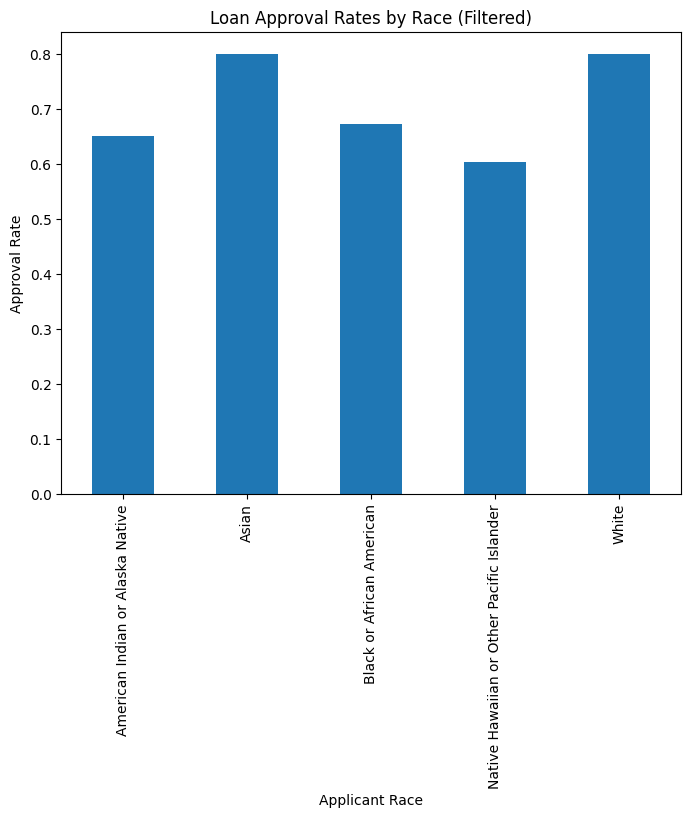

In [7]:
# Calculate approval rates (approved/total) for each race
race_approval_filtered = (
    data[data['action_taken'] == 1]
    .groupby('applicant_race-1')['action_taken']
    .count()
    / data.groupby('applicant_race-1')['action_taken'].count()
)

# Display results
print("\nApproval Rates by Race (Filtered):")
print(race_approval_filtered)
race_approval_filtered.plot(kind='bar', title="Loan Approval Rates by Race (Filtered)", figsize=(8, 6))
plt.xlabel("Applicant Race")
plt.ylabel("Approval Rate")
plt.show()


Approval Rates by Gender (Filtered):
applicant_sex
Female    0.779973
Male      0.786238
Name: action_taken, dtype: float64


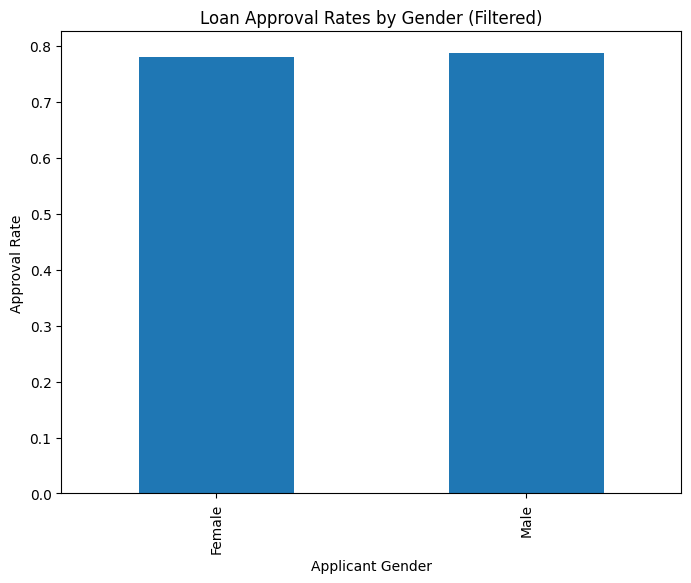

In [8]:
# Calculate approval rates (approved/total) for each gender
gender_approval_filtered = (
    data[data['action_taken'] == 1]
    .groupby('applicant_sex')['action_taken']
    .count()
    / data.groupby('applicant_sex')['action_taken'].count()
)

# Display results
print("\nApproval Rates by Gender (Filtered):")
print(gender_approval_filtered)

gender_approval_filtered.plot(kind='bar', title="Loan Approval Rates by Gender (Filtered)", figsize=(8, 6))
plt.xlabel("Applicant Gender")
plt.ylabel("Approval Rate")
plt.show()


Approval Rates by Income Bracket (Filtered):
income_bracket
Low          0.766489
Medium       0.861005
High         0.853019
Very High    0.862918
Name: action_taken, dtype: float64


C:\Users\Scarlett Medina\AppData\Local\Temp\ipykernel_34744\2657519174.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('income_bracket')['action_taken']
C:\Users\Scarlett Medina\AppData\Local\Temp\ipykernel_34744\2657519174.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / data.groupby('income_bracket')['action_taken'].count()


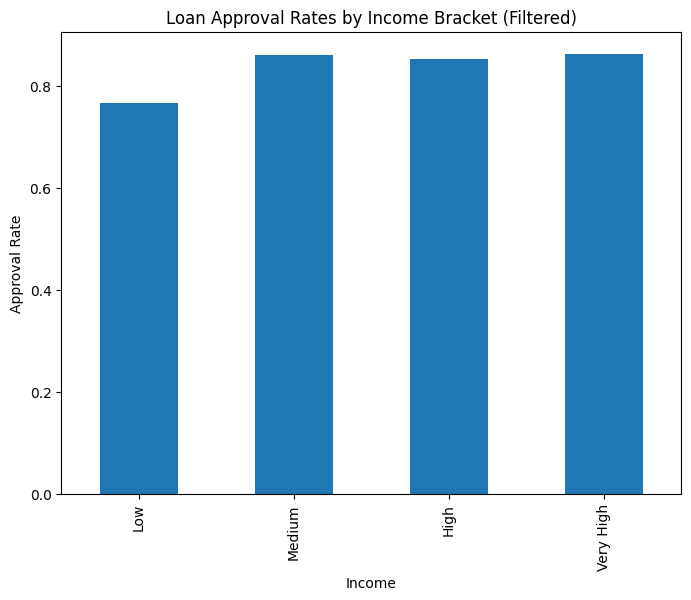

In [9]:
# Approval rates by income bracket
data['income_bracket'] = pd.cut(data['income'], bins=[0, 200, 400, 500, float('inf')],
                                labels=['Low', 'Medium', 'High', 'Very High'])
income_approval_filtered = (
    data[data['action_taken'] == 1]
    .groupby('income_bracket')['action_taken']
    .count()
    / data.groupby('income_bracket')['action_taken'].count()
)
print("\nApproval Rates by Income Bracket (Filtered):")
print(income_approval_filtered)

# Visualization for income bracket
income_approval_filtered.plot(kind='bar', title="Loan Approval Rates by Income Bracket (Filtered)", figsize=(8, 6))
plt.xlabel("Income")
plt.ylabel("Approval Rate")
plt.show()

In [10]:
# Investigate Statistical Significance

# Create contingency table for race and approval
race_contingency = pd.crosstab(data['applicant_race-1'], data['action_taken'] == 1)
chi2, p, dof, expected = chi2_contingency(race_contingency)
print("\nChi-Square Test for Race and Loan Approval:")
print(f"Chi2: {chi2}, P-Value: {p}")


Chi-Square Test for Race and Loan Approval:
Chi2: 1729.8572740397997, P-Value: 0.0


In [11]:
# Create contingency table for gender and approval
gender_contingency = pd.crosstab(data['applicant_sex'], data['action_taken'] == 1)
chi2, p, dof, expected = chi2_contingency(gender_contingency)
print("\nChi-Square Test for Gender and Loan Approval:")
print(f"Chi2: {chi2}, P-Value: {p}")


Chi-Square Test for Gender and Loan Approval:
Chi2: 8.56111867335026, P-Value: 0.0034341833475504463


In [12]:
# Create contingency table for income bracket and approval
income_contingency = pd.crosstab(data['income_bracket'], data['action_taken'] == 1)
chi2, p, dof, expected = chi2_contingency(income_contingency)
print("\nChi-Square Test for Income Bracket and Loan Approval:")
print(f"Chi2: {chi2}, P-Value: {p}")


Chi-Square Test for Income Bracket and Loan Approval:
Chi2: 1389.801602796382, P-Value: 4.810000242964453e-301


In [13]:
# Feature Preparation
X = data[['income', 'loan_amount', 'loan_to_value_ratio', 'debt_to_income_ratio', 'applicant_credit_score_type', 'applicant_sex', 'applicant_race-1']]
X = pd.get_dummies(X, columns=['applicant_sex', 'applicant_race-1'], drop_first=True)  # One-hot encode categorical variables
y = (data['action_taken'] == 1).astype(int)  # Binary target: 1 for approved, 0 otherwise

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [16]:
# Scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)  # Scale SMOTE-resampled data
X_test_scaled = scaler.transform(X_test)

In [17]:
# Logistic Regression (with increased max_iter and scaled data)
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_scaled, y_resampled)
y_pred_log = log_model.predict(X_test_scaled)

# Evaluate Logistic Regression
print("\nLogistic Regression Model Performance After SMOTE and Scaling:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Model Performance After SMOTE and Scaling:
Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.30      0.29     10413
           1       0.81      0.79      0.80     38351

    accuracy                           0.69     48764
   macro avg       0.54      0.54      0.54     48764
weighted avg       0.69      0.69      0.69     48764



In [18]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print("\nRandom Forest Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Model Performance:
Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.30      0.40     10413
           1       0.83      0.94      0.88     38351

    accuracy                           0.81     48764
   macro avg       0.71      0.62      0.64     48764
weighted avg       0.78      0.81      0.78     48764



In [19]:
# SHAP-integrated XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

C:\Users\Scarlett Medina\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [15:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Model Performance:
Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.27      0.39     10413
           1       0.83      0.97      0.89     38351

    accuracy                           0.82     48764
   macro avg       0.77      0.62      0.64     48764
weighted avg       0.80      0.82      0.79     48764



100%|===================| 48566/48764 [02:12<00:00]        


SHAP Summary Plot for XGBoost Model:


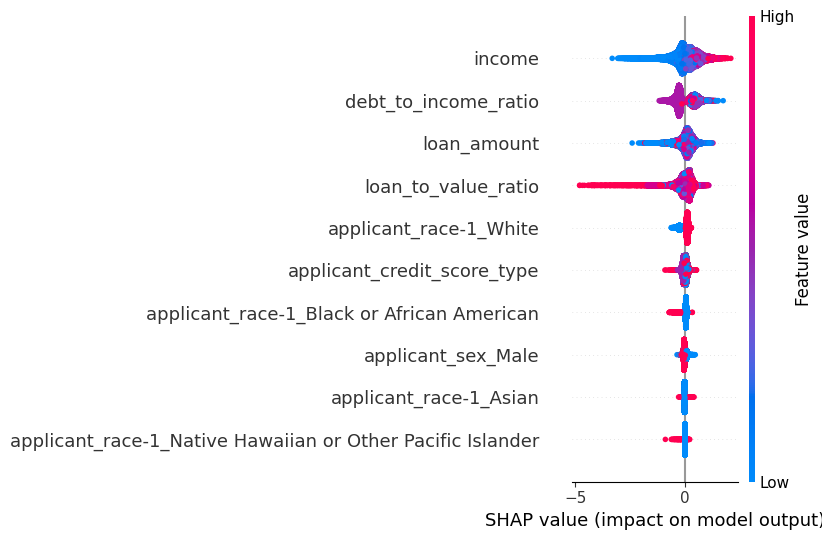


SHAP Waterfall Plot for First Prediction in Test Set:


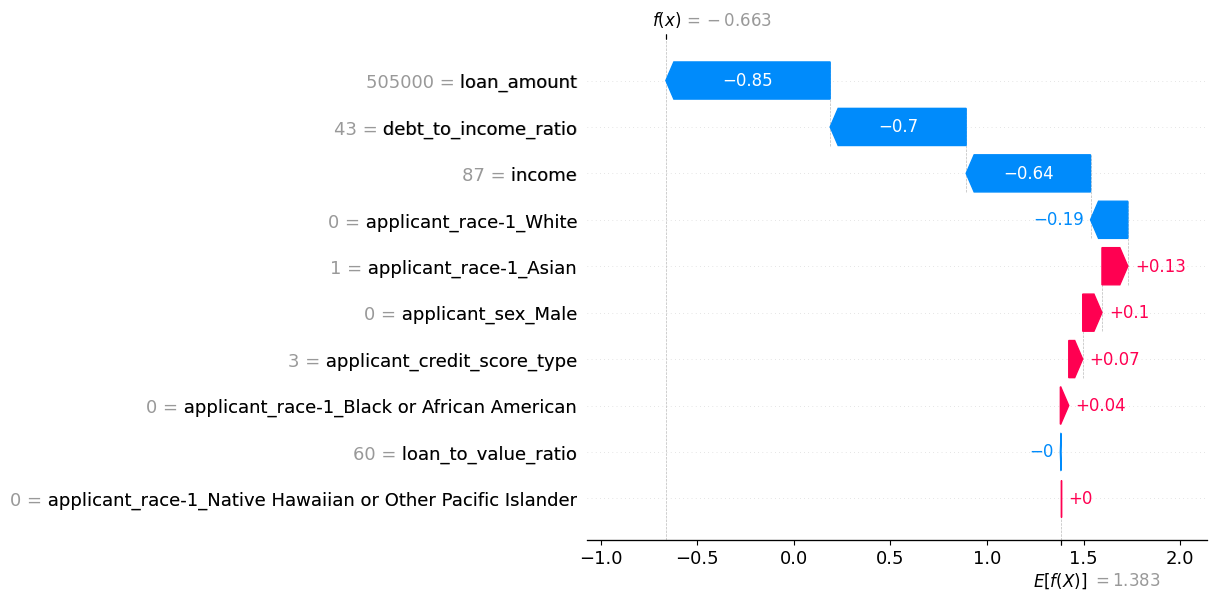

In [20]:
# SHAP Explainability
# Ensure all data in X_test is numeric and convert to float64
X_test_numeric = X_test.astype(np.float64)

# Import SHAP for model interpretability
explainer = shap.Explainer(xgb_model, X_test_numeric)
shap_values = explainer(X_test_numeric)

# SHAP Summary Plot
print("\nSHAP Summary Plot for XGBoost Model:")
shap.summary_plot(shap_values, X_test_numeric)

# SHAP Waterfall Plot for an Individual Prediction
print("\nSHAP Waterfall Plot for First Prediction in Test Set:")
shap.waterfall_plot(shap_values[0])


In [ ]:
# Feature Importance (Random Forest)
# Calculate feature importance for Random Forest
# Plot Random Forest Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()
